In [2]:
#export
from exp.nb_08 import * 

# Imagenette data 

In [3]:
from fastai.vision.all import URLs,untar_data
path = untar_data(URLs.IMAGENETTE_160)

In [4]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs=128

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

In [5]:
nfs = [32,64,128,256]

cbfs = [partial(AvgStatsCallback,accuracy), CudaCallback,
        partial(BatchTransformXCallback, norm_imagenette)]

In [6]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

run.fit(1, learn)

train: [1.7403141996250924, tensor(0.3992, device='cuda:0')]
valid: [1.6024165256767515, tensor(0.4718, device='cuda:0')]


In [7]:
class Optimizer():
    def __init__(self, params, steppers, **defaults):
        # might be a generator
        self.param_groups = list(params)
        # ensure params is a list of lists
        if not isinstance(self.param_groups[0], list): self.param_groups = [self.param_groups]
        self.hypers = [{**defaults} for p in self.param_groups]
        self.steppers = listify(steppers)

    def grad_params(self):
        return [(p,hyper) for pg,hyper in zip(self.param_groups,self.hypers)
            for p in pg if p.grad is not None]

    def zero_grad(self):
        for p,hyper in self.grad_params():
            p.grad.detach_()
            p.grad.zero_()

    def step(self):
        for p,hyper in self.grad_params(): compose(p, self.steppers, **hyper)

In [8]:
#export
def sgd_step(p, lr, **kwargs):
    p.data.add_(-lr, p.grad.data)
    return p

In [9]:
opt_func = partial(Optimizer, steppers=[sgd_step])

In [10]:
#export
class Recorder(Callback):
    def begin_fit(self): self.lrs,self.losses = [],[]

    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.hypers[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)
        
    def plot(self, skip_last=0):
        losses = [o.item() for o in self.losses]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(self.lrs[:n], losses[:n])

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_funcs):
        self.pname,self.sched_funcs = pname,listify(sched_funcs)

    def begin_batch(self): 
        if not self.in_train: return
        fs = self.sched_funcs
        if len(fs)==1: fs = fs*len(self.opt.param_groups)
        pos = self.n_epochs/self.epochs
        for f,h in zip(fs,self.opt.hypers): h[self.pname] = f(pos)
            
class LR_Find(Callback):
    _order=1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter,self.min_lr,self.max_lr = max_iter,min_lr,max_lr
        self.best_loss = 1e9
        
    def begin_batch(self): 
        if not self.in_train: return
        pos = self.n_iter/self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos
        for pg in self.opt.hypers: pg['lr'] = lr
            
    def after_step(self):
        if self.n_iter>=self.max_iter or self.loss>self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss

In [11]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 

In [12]:
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback, Recorder,
        partial(ParamScheduler, 'lr', sched)]

In [13]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs, opt_func=opt_func)

In [14]:
%time run.fit(1, learn)

train: [1.8107166312440595, tensor(0.3744, device='cuda:0')]
valid: [1.505288863455414, tensor(0.4917, device='cuda:0')]
CPU times: user 2.71 s, sys: 1.07 s, total: 3.78 s
Wall time: 5.95 s


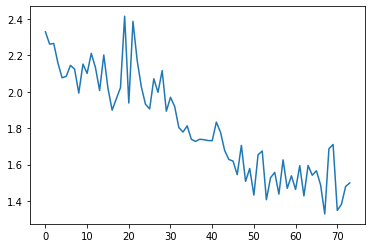

In [15]:
run.recorder.plot_loss()

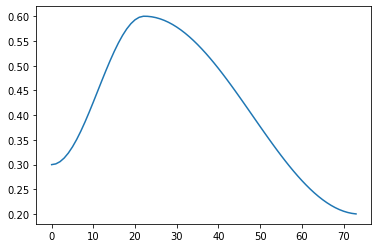

In [16]:
run.recorder.plot_lr()

In [17]:
(list(learn.model.parameters())[0])

Parameter containing:
tensor([[[[-4.7620e-01, -2.3178e-02, -7.5928e-01],
          [ 1.0217e-01,  3.2350e-01,  2.7659e-01],
          [-2.1274e-01, -3.8540e-01, -1.6326e-01]],

         [[-1.8691e-02, -1.4257e-01, -8.1247e-02],
          [ 4.7768e-01, -6.9312e-02, -7.6027e-02],
          [-4.0745e-01,  1.5561e-01,  4.4137e-02]],

         [[ 3.9099e-01, -2.0766e-01, -3.8864e-02],
          [-6.3955e-01, -3.2486e-01, -2.0091e-01],
          [ 1.2122e-01,  9.5227e-02, -2.8866e-01]]],


        [[[-1.3974e-02, -1.2619e-01,  1.2367e-01],
          [ 2.3855e-02, -2.5620e-02,  6.2989e-01],
          [-2.5192e-02,  2.2794e-01, -1.7295e-02]],

         [[ 2.3710e-01, -3.9693e-03,  1.1112e-01],
          [ 9.6567e-02, -1.7029e-01, -7.0185e-01],
          [ 1.3685e-01,  3.7936e-02,  2.4636e-01]],

         [[-8.4399e-02, -7.9989e-01,  3.0214e-02],
          [ 1.0959e-01,  3.5046e-01,  1.1344e-01],
          [ 2.7368e-01,  4.5789e-01,  4.9830e-01]]],


        [[[ 4.3352e-01, -5.4748e-01,  4.6853

In [18]:
#export
def weight_decay(p, lr, wd, **kwargs):
    p.data.mul_(1 - lr*wd)
    return p
weight_decay._defaults = dict(wd=0.)

In [19]:
#export
def l2_reg(p, lr, wd, **kwargs):
    p.grad.data.add_(wd, p.data)
    return p
l2_reg._defaults = dict(wd=0.)

In [20]:
#export
def maybe_update(os, dest, f):
    for o in os:
        for k,v in f(o).items():
            if k not in dest: dest[k] = v

def get_defaults(d): return getattr(d,'_defaults',{})

In [21]:
#export
class Optimizer():
    def __init__(self, params, steppers, **defaults):
        self.steppers = listify(steppers)
        maybe_update(self.steppers, defaults, get_defaults)
        # might be a generator
        self.param_groups = list(params)
        # ensure params is a list of lists
        if not isinstance(self.param_groups[0], list): self.param_groups = [self.param_groups]
        self.hypers = [{**defaults} for p in self.param_groups]

    def grad_params(self):
        return [(p,hyper) for pg,hyper in zip(self.param_groups,self.hypers)
            for p in pg if p.grad is not None]

    def zero_grad(self):
        for p,hyper in self.grad_params():
            p.grad.detach_()
            p.grad.zero_()
    
    def __repr__(self):
        x = ''''''
        for it in self.hypers:
            x = x +  str(it)
        return x

    def step(self):
        for p,hyper in self.grad_params(): compose(p, self.steppers, **hyper)

In [22]:
#export 
sgd_opt = partial(Optimizer, steppers=[weight_decay, sgd_step])

In [23]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs, opt_func=sgd_opt)

In [24]:
model = learn.model

In [25]:
opt = sgd_opt(model.parameters(), lr=0.1,wd=0.)
test_eq(opt.hypers[0]['wd'], 0.)
test_eq(opt.hypers[0]['lr'], 0.1)

In [26]:
len(opt.param_groups)

1

In [27]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=Fa

In [28]:
x+'sd'

NameError: name 'x' is not defined

In [31]:
cbfs = [partial(AvgStatsCallback,accuracy), CudaCallback]

In [41]:
learn,run = get_learn_run(nfs, data, 0.3, conv_layer, cbs=cbfs, opt_func=partial(sgd_opt, wd=0.01))
run.fit(1, learn)

train: [1.7470252435579259, tensor(0.3995, device='cuda:0')]
valid: [1.867669685509554, tensor(0.3595, device='cuda:0')]


In [33]:
run.fit(1, learn)

train: [1.7685351954403845, tensor(0.3827, device='cuda:0')]
valid: [1.674035753383758, tensor(0.4130, device='cuda:0')]


In [34]:
get_learn_run

<function exp.nb_08.get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, **kwargs)>

## Momentum 

In [35]:
#export
class StatefulOptimizer(Optimizer):
    def __init__(self, params, steppers, stats=None, **defaults): 
        self.stats = listify(stats)
        maybe_update(self.stats, defaults, get_defaults)
        super().__init__(params, steppers, **defaults)
        self.state = {}
        
    def step(self):
        for p,hyper in self.grad_params():
            if p not in self.state:
                #Create a state for p and call all the statistics to initialize it.
                self.state[p] = {}
                maybe_update(self.stats, self.state[p], lambda o: o.init_state(p))
            state = self.state[p]
            for stat in self.stats: state = stat.update(p, state, **hyper)
            compose(p, self.steppers, **state, **hyper)
            self.state[p] = state

In [36]:
#export
class Stat():
    _defaults = {}
    def init_state(self, p): raise NotImplementedError
    def update(self, p, state, **kwargs): raise NotImplementedError    

In [37]:
#export
class AverageGrad(Stat):
    _defaults = dict(mom=0.9)

    def init_state(self, p): return {'grad_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, state, mom, **kwargs):
        state['grad_avg'].mul_(mom).add_(p.grad.data)
        return state

In [38]:
#export
def momentum_step(p, lr, grad_avg, **kwargs):
    p.data.add_(-lr, grad_avg)
    return p

In [43]:
#export
sgd_mom_opt = partial(StatefulOptimizer, steppers=[momentum_step],
                  stats=AverageGrad())

In [47]:
learn,run = get_learn_run(nfs, data, 0.3, conv_layer, cbs=cbfs, opt_func=sgd_mom_opt)
run.fit(10, learn)

train: [2.043192341456331, tensor(0.3378, device='cuda:0')]
valid: [1.911136917794586, tensor(0.3689, device='cuda:0')]
train: [1.457113034144313, tensor(0.5118, device='cuda:0')]
valid: [1.4235240843949044, tensor(0.5264, device='cuda:0')]
train: [1.2276677719730171, tensor(0.5944, device='cuda:0')]
valid: [1.6822891371417197, tensor(0.4622, device='cuda:0')]
train: [1.0494394949968318, tensor(0.6559, device='cuda:0')]
valid: [1.6051436853105097, tensor(0.5073, device='cuda:0')]
train: [0.88725039850433, tensor(0.7055, device='cuda:0')]
valid: [1.406947029259554, tensor(0.5603, device='cuda:0')]
train: [0.7468407393534164, tensor(0.7516, device='cuda:0')]
valid: [1.6972849074442675, tensor(0.5225, device='cuda:0')]
train: [0.6451804696575668, tensor(0.7839, device='cuda:0')]
valid: [1.5154477259156052, tensor(0.5636, device='cuda:0')]
train: [0.5299186613884782, tensor(0.8238, device='cuda:0')]
valid: [1.8397499502388535, tensor(0.5679, device='cuda:0')]
train: [0.36993345678991973, t

train: [1.9493342585014257, tensor(0.3515, device='cuda:0')]
valid: [1.9772220839968153, tensor(0.3552, device='cuda:0')]


## What does momentum look like? 

In [85]:
x = torch.linspace(-4, 4, 200)
y = torch.randn(200) + 0.3
betas = [0.5, 0.7, 0.9, 0.99]

In [86]:
def plot_mom(f):
    _,axs = plt.subplots(2,2, figsize=(12,8))
    for beta,ax in zip(betas, axs.flatten()):
        ax.plot(y, linestyle='None', marker='.')
        avg,res = None,[]
        for i,yi in enumerate(y):
            avg,p = f(avg, beta, yi, i)
            res.append(p)
        ax.plot(res, color='red')
        ax.set_title(f'beta={beta}')

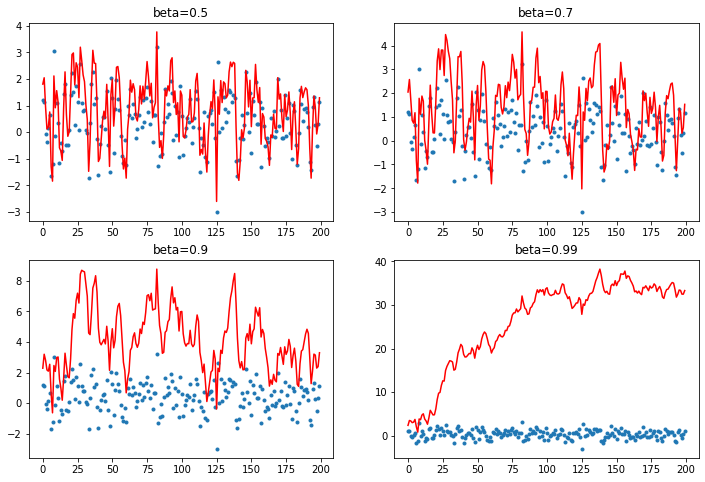

In [87]:
def mom1(avg, beta, yi, i): 
    if avg is None: avg=yi
    res = beta*avg + yi
    return res,res
plot_mom(mom1)

In [88]:
#export
def lin_comb(v1, v2, beta): return beta*v1 + (1-beta)*v2

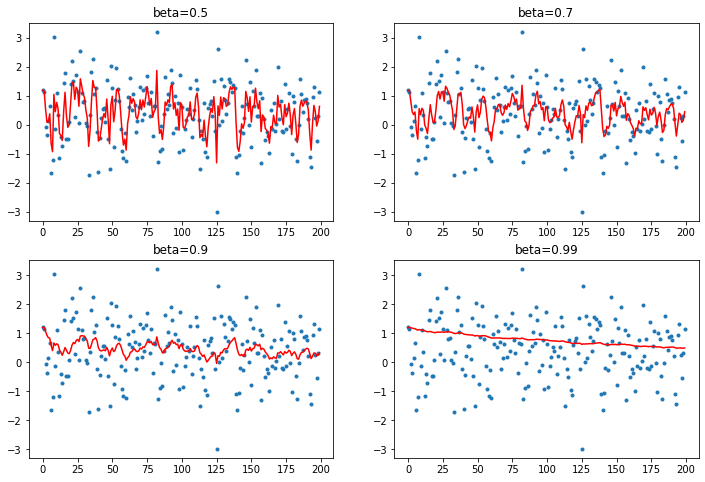

In [89]:
def mom2(avg, beta, yi, i):
    if avg is None: avg=yi
    avg = lin_comb(avg, yi, beta)
    return avg, avg
plot_mom(mom2)

In [90]:
y = 1 - (x/3) ** 2 + torch.randn(200) * 0.1

In [91]:
y[0]=0.5

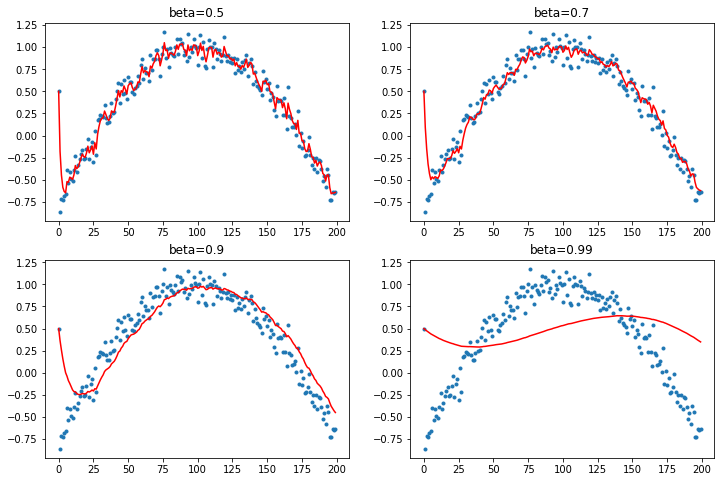

In [92]:
plot_mom(mom2)

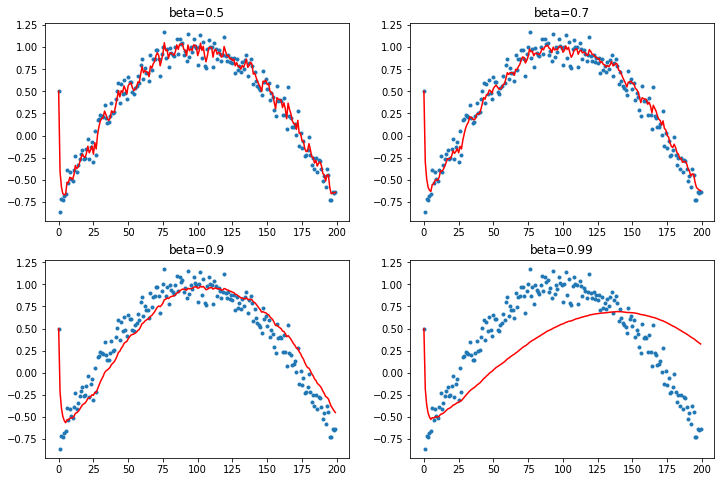

In [93]:
def mom3(avg, beta, yi, i):
    if avg is None: avg=0
    avg = lin_comb(avg, yi, beta)
    return avg, avg/(1-beta**(i+1))
plot_mom(mom3)

# Adam Khor 

In [94]:
#export
class AverageGrad(Stat):
    _defaults = dict(mom=0.9)
    
    def __init__(self, dampening:bool=False): self.dampening=dampening
    def init_state(self, p): return {'grad_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, state, mom, **kwargs):
        state['mom_damp'] = 1-mom if self.dampening else 1.
        state['grad_avg'].mul_(mom).add_(state['mom_damp'], p.grad.data)
        return state

In [95]:
#export
class AverageSqrGrad(Stat):
    _defaults = dict(sqr_mom=0.99)
    
    def __init__(self, dampening:bool=True): self.dampening=dampening
    def init_state(self, p): return {'sqr_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, state, sqr_mom, **kwargs):
        state['sqr_damp'] = 1-sqr_mom if self.dampening else 1.
        state['sqr_avg'].mul_(sqr_mom).addcmul_(state['sqr_damp'], p.grad.data, p.grad.data)
        return state

In [96]:
#export
class StepCount(Stat):
    def init_state(self, p): return {'step': 0}
    def update(self, p, state, **kwargs):
        state['step'] += 1
        return state

In [97]:
#export
def debias(mom, damp, step): return damp * (1 - mom**step) / (1-mom)

In [98]:
#export
def adam_step(p, lr, mom, mom_damp, step, sqr_mom, sqr_damp, grad_avg, sqr_avg, eps, **kwargs):
    debias1 = debias(mom,     mom_damp, step)
    debias2 = debias(sqr_mom, sqr_damp, step)
    p.data.addcdiv_(-lr / debias1, grad_avg, (sqr_avg/debias2).sqrt() + eps)
    return p
adam_step._defaults = dict(eps=1e-5)

In [99]:
#export
def adam_opt(xtra_step=None, **kwargs):
    return partial(StatefulOptimizer, steppers=[adam_step,weight_decay]+listify(xtra_step),
                   stats=[AverageGrad(dampening=True), AverageSqrGrad(), StepCount()], **kwargs)

In [113]:
learn,run = get_learn_run(nfs, data, 0.3, conv_layer, cbs=cbfs, opt_func=sgd_mom_opt)
run.fit(20, learn)

train: [1.950727167269511, tensor(0.3482, device='cuda:0')]
valid: [1.9828794287420382, tensor(0.3282, device='cuda:0')]
train: [1.4185708380636814, tensor(0.5249, device='cuda:0')]
valid: [1.7476148238455413, tensor(0.3985, device='cuda:0')]
train: [1.2283505097225156, tensor(0.5938, device='cuda:0')]
valid: [1.9262884404856688, tensor(0.3954, device='cuda:0')]
train: [1.087560910107984, tensor(0.6448, device='cuda:0')]
valid: [1.9688818670382167, tensor(0.3926, device='cuda:0')]
train: [1.0110542667190305, tensor(0.6732, device='cuda:0')]
valid: [1.492116092754777, tensor(0.5399, device='cuda:0')]
train: [0.9143180625594044, tensor(0.6965, device='cuda:0')]
valid: [1.8425464022691083, tensor(0.4861, device='cuda:0')]
train: [0.9161304115732918, tensor(0.6991, device='cuda:0')]
valid: [3.226958349920382, tensor(0.3414, device='cuda:0')]
train: [0.8311666379270515, tensor(0.7283, device='cuda:0')]
valid: [1.4055414012738854, tensor(0.5755, device='cuda:0')]
train: [0.788116774144577, t

In [114]:
learn,run = get_learn_run(nfs, data, 0.01, conv_layer, cbs=cbfs, opt_func=adam_opt())
run.fit(20, learn)

train: [1.8181067001531312, tensor(0.3703, device='cuda:0')]
valid: [1.9652443272292994, tensor(0.3641, device='cuda:0')]
train: [1.4076152692338155, tensor(0.5353, device='cuda:0')]
valid: [1.4584718351910828, tensor(0.5152, device='cuda:0')]
train: [1.1385966913414827, tensor(0.6273, device='cuda:0')]
valid: [1.2549030901671974, tensor(0.5862, device='cuda:0')]
train: [0.9595953324664696, tensor(0.6819, device='cuda:0')]
valid: [1.2343114301353504, tensor(0.6120, device='cuda:0')]
train: [0.7940705154649382, tensor(0.7378, device='cuda:0')]
valid: [1.2064770352308918, tensor(0.6270, device='cuda:0')]
train: [0.630480929958945, tensor(0.7969, device='cuda:0')]
valid: [1.2148397691082802, tensor(0.6527, device='cuda:0')]
train: [0.49068625044553277, tensor(0.8376, device='cuda:0')]
valid: [1.2729671327627388, tensor(0.6382, device='cuda:0')]
train: [0.35521514695981626, tensor(0.8821, device='cuda:0')]
valid: [1.4041125099522294, tensor(0.6517, device='cuda:0')]
train: [0.2390054728340

In [112]:
cbfs

[functools.partial(<class 'exp.nb_05b.AvgStatsCallback'>, <function accuracy at 0x7f3e24a0c2f0>),
 exp.nb_06.CudaCallback]

## LAMB 

In [116]:
def lamb_step(p, lr, mom, mom_damp, step, sqr_mom, sqr_damp, grad_avg, sqr_avg, eps, wd, **kwargs):
    debias1 = debias(mom,     mom_damp, step)
    debias2 = debias(sqr_mom, sqr_damp, step)
    r1 = p.data.pow(2).mean().sqrt()
    step = (grad_avg/debias1) / ((sqr_avg/debias2).sqrt()+eps) + wd*p.data
    r2 = step.pow(2).mean().sqrt()
    p.data.add_(-lr * min(r1/r2,10), step)
    return p
lamb_step._defaults = dict(eps=1e-6, wd=0.)

In [117]:
lamb = partial(StatefulOptimizer, steppers=lamb_step, stats=[AverageGrad(dampening=True), AverageSqrGrad(), StepCount()])

In [118]:
learn,run = get_learn_run(nfs, data, 0.003, conv_layer, cbs=cbfs, opt_func=lamb)

In [120]:
run.fit(10, learn)

train: [0.7950381054295597, tensor(0.7456, device='cuda:0')]
valid: [1.2901740396098726, tensor(0.5903, device='cuda:0')]
train: [0.5659956275906907, tensor(0.8162, device='cuda:0')]
valid: [1.3356675457802547, tensor(0.6104, device='cuda:0')]
train: [0.3752120406061886, tensor(0.8844, device='cuda:0')]
valid: [1.4337354448646498, tensor(0.5987, device='cuda:0')]
train: [0.22768814065965254, tensor(0.9311, device='cuda:0')]
valid: [2.21831633160828, tensor(0.5108, device='cuda:0')]
train: [0.15919780016121687, tensor(0.9522, device='cuda:0')]
valid: [1.9332135748407644, tensor(0.5699, device='cuda:0')]
train: [0.1212070411507287, tensor(0.9624, device='cuda:0')]
valid: [2.0514007762738853, tensor(0.5809, device='cuda:0')]
train: [0.1055447329360941, tensor(0.9660, device='cuda:0')]
valid: [2.257800557324841, tensor(0.5786, device='cuda:0')]
train: [0.09799553043979037, tensor(0.9678, device='cuda:0')]
valid: [2.237617685111465, tensor(0.5888, device='cuda:0')]
train: [0.090596218272289

In [48]:
!python notebook2script.py 09_optimizers.ipynb 

Converted 09_optimizers.ipynb to exp/nb_09.py
